# House-Cleaning: Getting rid of outlier with Gauss

Working with real-world data presents many challenges that sanitized data from text book simply don't have. One of them is how to handle outlier. Outliers are especially common in data obtained through manual input. For example, on an online listing site, someone might have accidently pressed the zero-key a bit too often and suddenly the small appartment for sale is as expensive a palace. However, other outliers can be more tricky. What is for example with the old villa in small town offered for 1€? It might be one of these run-down houses in a dying town and thus could be the actual offering price.

Very roughly we can say that there are two categories of outliers:
- Outliers that are not real, but instead result from an error or mistake. I'll call them "proper outlier".
- Outliers that are real, but look extremely different compared with other data. I'll call them "improper outlier".

Deciding which type of outlier one is dealing with can be difficutl and one usually needs to check the context. Ideally, you'll only want to discard "proper outliers" and keep the improper ones. However, both types of outlier can be problematic for any subsequent analysis or modelling. In this post, I will focus on identifying outliers in general and won't talk much about distinguishing between the two. Nevertheless, I highly recommend you to always check what type of outlier you're dealing with and to determine the cause of the outlier.
But now let's talk about how we can identify outliers.

A year ago, I scraped some [online rental offers](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) and except for throwing away some duplicates that arose probably due to the way I scraped them, this is still very much the raw data and thus still has a bunch of outliers.

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklego.mixture import GMMClassifier, GMMOutlierDetector
blue = "#008fd5"
red = "#fc4f30"

In [7]:
plt.style.use('corrie')

In [269]:
d = pd.read_csv("/home/corrie/Documents/Projects/immoscout/data/immo_data_feb_2020.csv")
d["totalRent"] = np.where((d["totalRent"].isnull()) | (d["totalRent"] == 0),
                          np.where( d["serviceCharge"].notnull(), d["baseRent"] + d["serviceCharge"], d["baseRent"]),
                          d["totalRent"])

The easiest way to see if there are any outliers in your data is to just plot it. Let's look at the total rent versus the living space:

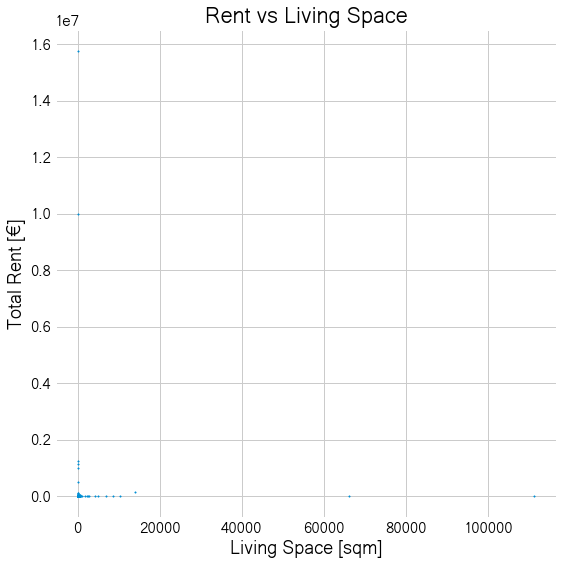

In [270]:
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(d["livingSpace"],d["totalRent"], s=2)
ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_title("Rent vs Living Space")
plt.show()

Does this plot remind you of all the times you wanted to have a quick look at your data, see if there's any interesting pattern or some insight to be gained just to then be reminded of the fact that your data is still dirty? It definitely does for me. There are some flats or houses that are larger than 10,000 sqm which, according to [the Measure of Things](https://www.bluebulbprojects.com/MeasureOfThings/results.php?comp=area&unit=m2&amt=10000&sort=pr&p=1) is twice as big as Bill Gate's home. And that place with a rent of 10 million? Doesn't look right.

One way to get a nicer plot, is to just eyeball the axes, use whatever knowledge you have about rents and flats and pick some threshold above or below which you discard the data:

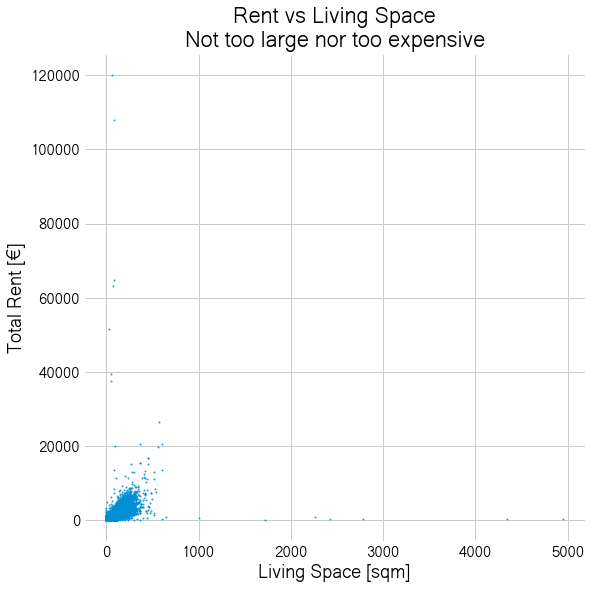

In [271]:
too_large = d["livingSpace"] > 5000
too_expensive = d["totalRent"] > 2e5
alrightish = ~too_large & ~too_expensive
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(d["livingSpace"][alrightish],d["totalRent"][alrightish], s=2, alpha=0.8)
ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_title("Rent vs Living Space\nNot too large nor too expensive")
plt.show()

It looks better than before but still not great. One could iteratively try smaller thresholds until the blob in the bottom left covers most of the plot area. I think this can be a valid way to obtain reasonable thresholds but might not be very feasible if you have more variables and it's also not quite satisfying if you like to automate stuff.
In this blog post, I want to describe two simple methods to prune outliers.

The first one is the interquartile range rule and might be familiar to you if you had some classes in statistics.

## Interquartile Range Rule
[Quartiles](https://en.wikipedia.org/wiki/Quartile) are important summary statistics of any continuous data. There are three quartiles, $Q_1$, $Q_2$ and $Q_3$, which are the 25th, 50th (the median) and 75th percentiles. The interquartile range $IQR$ is then the difference between the first and third quartile: 
$IQR = Q_3 - Q_1$
The interquartile range thus covers half of the data which is also why they're used for boxplots: the boxy part is exactly the interquartile range. 

A good rule of thumb is to say that every point above $Q_3 +1.5 IQR$ or below $Q_1 - 1.5 IQR$ is an outlier.
In python, we can compute this as follows:

In [272]:
def iqr(data):
    """compute the interquartile range (excluding nan)"""
    return np.nanquantile(data, 0.75) - np.nanquantile(data, 0.25)

def iqr_rule(data, factor=1.5):
    """returns an outlier filter mask using the iqr rule"""
    iqr_ = iqr(data)
    upper_fence = np.nanquantile(data, 0.75) + factor*iqr_
    lower_fence = np.nanquantile(data, 0.25) - factor*iqr_
    return (data <= upper_fence) & (data >= lower_fence)

For our example, the same plot as above after applying the IQR rule to both our variables then looks like this:

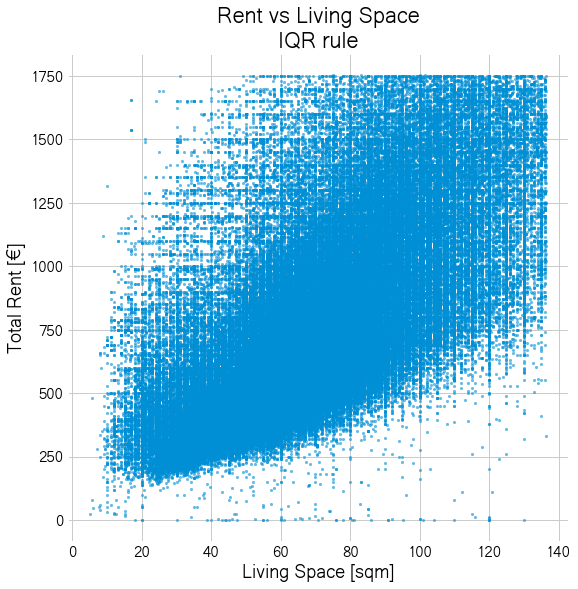

In [273]:
alrightish = iqr_rule(d["livingSpace"]) & iqr_rule(d["totalRent"])
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(d["livingSpace"][alrightish],d["totalRent"][alrightish], s=6, alpha=0.6)
ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_title("Rent vs Living Space\nIQR rule")
plt.show()

Nice! The blob now covers the whole plot area and we get a much better view of the largest chunk of the data.
However, there is a hard, rectangular edge. It looks like we cut off the data too generously and a considereable part of the data is now hidden from view because they're either larger than 140sqm or more expensive than 1750€ per month. And while I personally wouldn't rent a flat this expensive, it still sounds like very realistic rents and sizes. If I would have a flat share with three or four friends, 2000€ seems like a reasonable rent in Berlin.

To adjust this rule of thumb, we can increase the factor with which we multiply the IQR. Instead of 1.5, we can use e.g. 2.5:

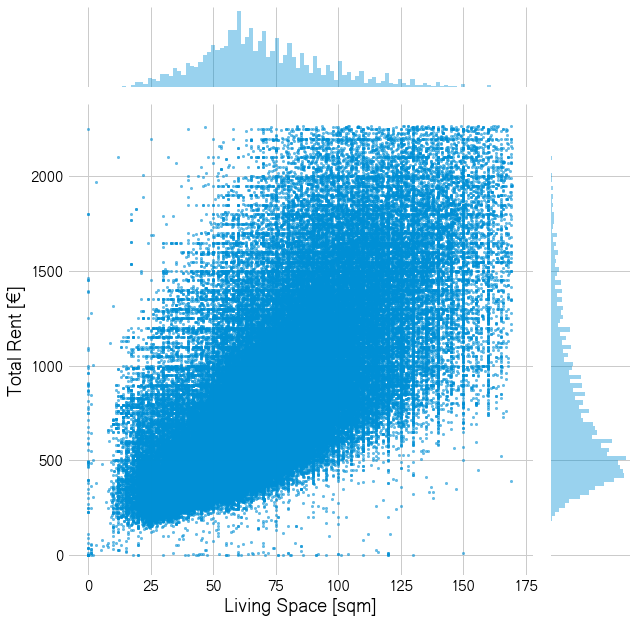

In [274]:
iqr_rule_25 = lambda x: iqr_rule(x, factor=2.5)
alrightish = iqr_rule_25(d["livingSpace"]) & iqr_rule_25(d["totalRent"])
g = sns.jointplot(x=d["livingSpace"][alrightish],y=d["totalRent"][alrightish],
              s=6, alpha=0.6, height=9, marginal_kws=dict(bins=100) )
g.ax_joint.set(xlabel="Living Space [sqm]", ylabel="Total Rent [€]")

plt.show()

The plot has less cut-off than before but there's still a rectangular border.
I also added the histograms for each margin to get a look at the individual distributions. One can see that the distribution for the rent does not follow a normal distribution but is highly right-skewed. The distribution for the living space also seems to be slightly right-skewed.
Furthermore, we know that both rents and living space should only have values strictly above zero. (There are actually a few observations that have a value of zero for the living space or the total rent. This is clearly not realistic.) So it is probably more reasonable to model both variables assuming a log-normal distribution. 
I manually assigned values of 0.5 to the observations that have a value of zero. Seems somehow reasonable to say that there's not much difference between the rent being 0€ or 50ct.
Let's look at the whole data again but this time with log-transformed rent and living space:

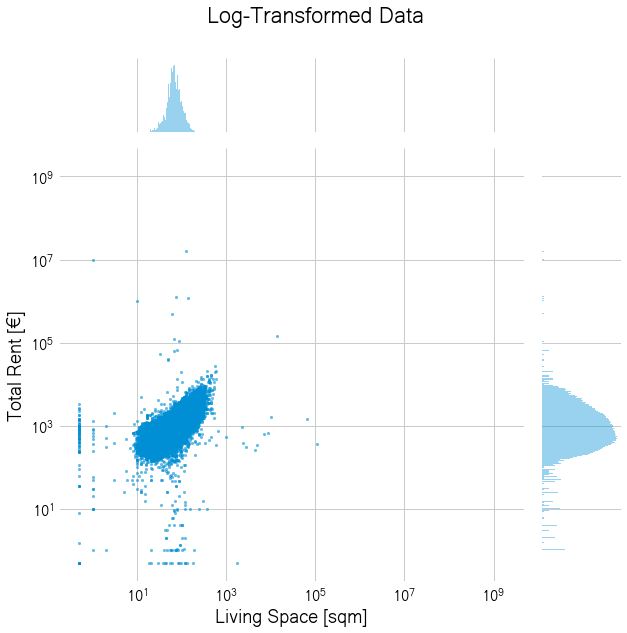

In [275]:
d["livingSpace_m"] =  np.where(d["livingSpace"] <= 0, 0.5, d["livingSpace"])
d["totalRent_m"] = np.where(d["totalRent"] <= 0, 0.5, d["totalRent"])
logbins=np.logspace(0,np.log(10e3),500)
g = sns.jointplot(x=d["livingSpace_m"],y=d["totalRent_m"], 
                  s=6, alpha=0.6, height=9, marginal_kws=dict(bins=logbins)
                 )
g.ax_joint.set_yscale("log")
g.ax_marg_x.set_xscale("log")
g.ax_marg_y.set_xscale("log")
g.ax_joint.set_xscale("log")
g.ax_joint.set(xlabel="Living Space [sqm]", ylabel="Total Rent [€]")
plt.subplots_adjust(top=0.9)
plt.suptitle("Log-Transformed Data")
plt.show()

Note that this is the same plot as our first one, just in log-scale. So only transforming the data already brought a big improvement.

Now using the IQR rule on the transformed data, we get the following result:

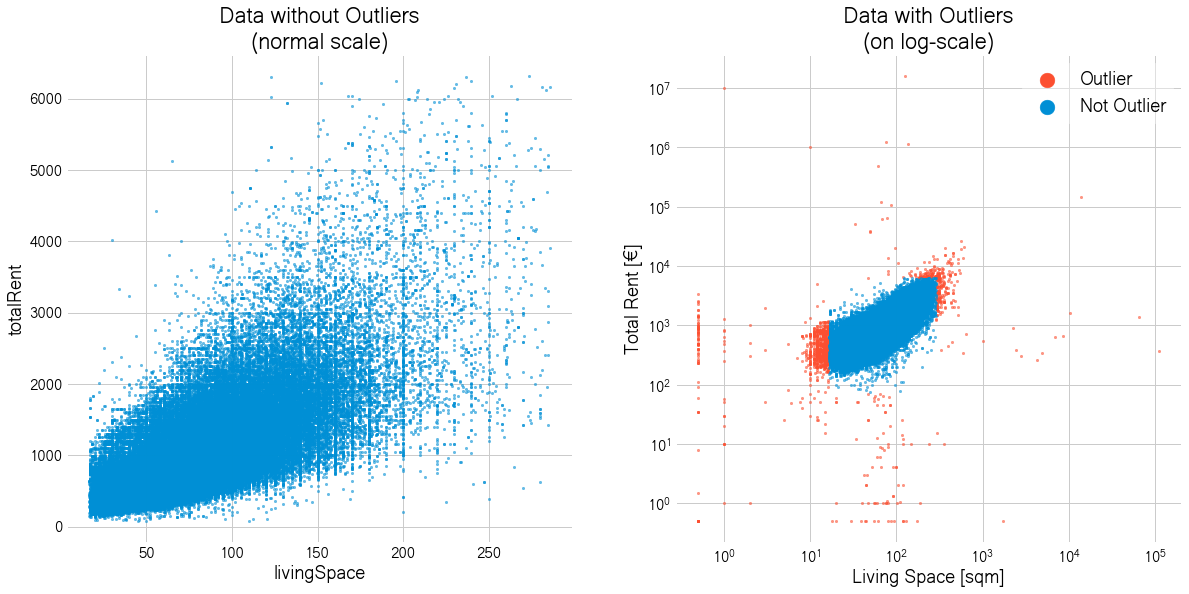

In [301]:
d["logRent"] = np.log(d["totalRent_m"])
d["logSpace"] = np.log(d["livingSpace_m"])

fig, ax  = plt.subplots(figsize=(20,9), nrows=1, ncols=2)
alrightish = iqr_rule_25(d["logSpace"]) & iqr_rule_25(d["logRent"])
d["outlier"] = np.where(alrightish, "no_outlier", "outlier")
max_space = d[d.outlier == "no_outlier"].livingSpace.max()
max_rent = d[d.outlier == "no_outlier"].totalRent.max()
ax[1].scatter(x=d[d.outlier == "outlier"].livingSpace_m, c=red, alpha=0.6,
              y=d[d.outlier == "outlier"].totalRent_m, label="Outlier", s=6)

ax[1].scatter(x=d[d.outlier == "no_outlier"].livingSpace_m, c=blue, alpha=0.6,
              y=d[d.outlier == "no_outlier"].totalRent_m, label="Not Outlier", s=6)
ax[1].set_yscale("log")
ax[1].set_xscale("log")
#ax[1].set_xlim(-40, max_space + 200)
#ax[1].set_ylim(-500, max_rent + 800)

ax[1].set(xlabel="Living Space [sqm]", ylabel="Total Rent [€]")
ax[1].set_title("Data with Outliers\n(on log-scale)")
leg = ax[1].legend(markerscale=6)
for lh in leg.legendHandles:
    lh.set_alpha(1)

ax[0].scatter(d["livingSpace"][alrightish],d["totalRent"][alrightish], s=6, alpha=0.6)
ax[0].set(xlabel="livingSpace", ylabel="totalRent")
ax[0].set_title("Data without Outliers\n(normal scale)")

plt.show()

On the left, we see the data after removing the so identified outliers. The rectangular borders don't seem as bad as before but they're still there. Especially in the bottom left, there's a hard cut throwing away places that are too small. The smallest place that is not considered an outlier has a size of 16.97sqm. As often with thresholds, there remains the question why a flat of size 16.97sqm is okay but many flats of size 16.6sqm are not. One problem here is that the data likely also contains many shared flats. The size in the offer would then be the size of the room but the rent would be relatively high for such a small living area since one also pays for common areas in a shared flat.

On the right, I plotted all data and highlighted outliers in red. In total, around 1500 data points were classified as outliers. This is less than 1% of the total data.
In the right plot we can see that we not only lose data in the lower left corner but there's also a hard corner in the upper right. One could increase the factor used in the IQR rule but this would still not lead to optimal results.
One problem with the IQR rule is that we apply it separately on each variable. That is, the cut-off window will always be rectangular. In this example though, the two variables are highly correlated and thus a rectangular window is not a good fit. Better would be to use an oval cut-off window.
Such an oval window can for example be obtained by a multivariate Gaussian distribution.

## Gaussian Mixtures for Outlier Detection
So how does this work? We first fit a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) on our data and then compute the likelihood for each data point according to this distribution. All data points with a very low likelihood, much lower than the other data points, are then classified as outliers. Let's visualize this:

In [279]:
# thanks joseph https://joseph-long.com/writing/colorbars/
def colorbar(mappable, label):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax, label=label)
    plt.sca(last_axes)
    return cbar

In [288]:
from sklego.mixture import BayesianGMMOutlierDetector

np.random.seed(20)
exam = np.random.multivariate_normal([-10, 2], [[1.8, 1.7], [1.7, 2.3]], (1000,))
outlier = np.array([[-7, -1], [-8, 7.5]])
exam = np.vstack([exam, outlier])
mod = BayesianGMMOutlierDetector(n_components=1, threshold=3.5, method="stddev").fit(exam)

df_ex= pd.DataFrame({"x1": exam[:, 0], "x2": exam[:, 1],
                   "loglik": -mod.score_samples(exam), 
                   "prediction": mod.predict(exam).astype(str)})

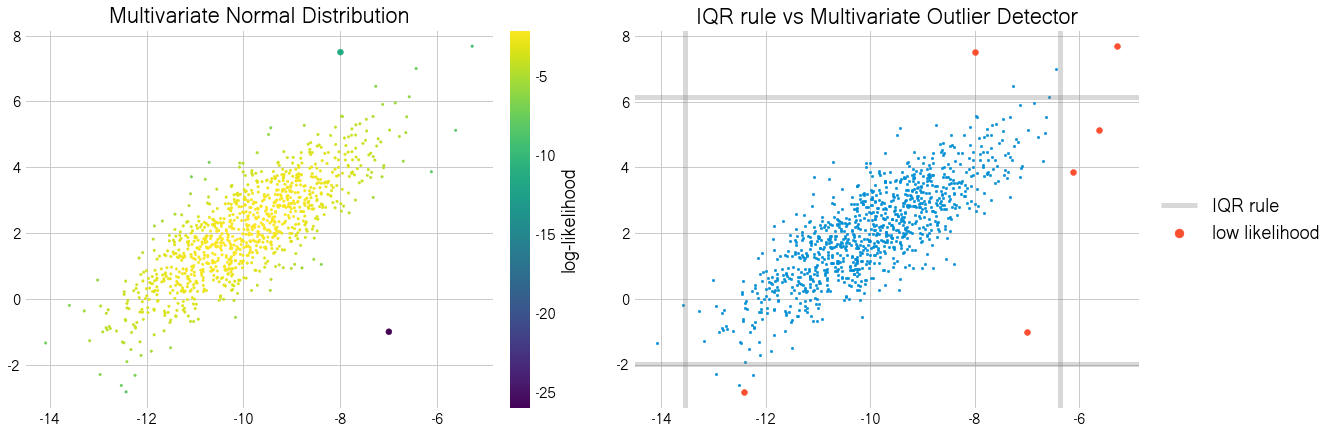

In [289]:
fig, axes = plt.subplots(figsize=(20,7), nrows=1, ncols=2)
norm = mpl.colors.Normalize(vmin=df_ex.loglik.min(),vmax=df_ex.loglik.max())
scatter = axes[0].scatter(df_ex.x1, df_ex.x2, 
                          c=df_ex.loglik, cmap="viridis", norm=norm,
                          s=6, label="log-likelihood")
colorbar(scatter, label="log-likelihood")
axes[0].scatter(outlier[:,0], outlier[:,1], 
                c=df_ex.loglik[1000:] ,cmap="viridis", norm=norm,
                s=35)
axes[0].set_title("Multivariate Normal Distribution")



factor = 1.5
x1_max = np.nanquantile(exam[:,0], 0.75) + factor*iqr(exam[:,0])
x1_min = np.nanquantile(exam[:,0], 0.25) - factor*iqr(exam[:,0])

x2_max = np.nanquantile(exam[:,1], 0.75) + factor*iqr(exam[:,1])
x2_min = np.nanquantile(exam[:,1], 0.25) - factor*iqr(exam[:,1])


axes[1].scatter(df_ex.x1[df_ex.prediction == "-1"], df_ex.x2[df_ex.prediction == "-1"], c=red, label="low likelihood", s=35)
axes[1].scatter(df_ex.x1[df_ex.prediction == "1"], df_ex.x2[df_ex.prediction == "1"], c=blue, s=6)
axes[1].axvline(x=x1_max, c="grey", label="IQR rule", alpha=0.3, linewidth=5)
axes[1].axvline(x=x1_min, c="grey", alpha=0.3, linewidth=5)
axes[1].axhline(y=x2_max, c="grey", alpha=0.3, linewidth=5)
axes[1].axhline(y=x2_min, c="grey", alpha=0.3, linewidth=5)
axes[1].set_title("IQR rule vs Multivariate Outlier Detector")
axes[1].legend(markerscale=1.5, bbox_to_anchor=(1.01, .6))
plt.show()

On the left are points sampled from a multivariate normal with a high correlation between the $x$ and $y$ variable, similarly as in our data. The points are colored by their log likelihood. I added two outliers by hand, plotted slightly larger on the left, and as you can see they have a much lower log likelihood compared to the other points. We can use this and classify all points with a very low likelihood as outliers.
On the right, we see the same points where now all points with a low likelihood are in red. The grey lines gives the rectangular threshold as obtained from the IQR rule. There are quite a few points at the lower left and upper right corner that would be classified as outlier by the IQR rule whereas it would miss at least one of the manually added outlier points.

Luckily, there's a package for that: [scikit-lego](https://github.com/koaning/scikit-lego). The package follows the scikit-learn API and adds some additional classifiers (such as the Gaussian mixture classifier and outlier detector) but also useful transformers and a pipeline debugger.
The function I'm going to use does the whole procedure described above: it fits a multivariate Gaussian to our data, computes the likelihood for each point and points with a low likelihood are flagged as outlier. Vincent, one of the developer of scikit-lego, explains this in a few more sentences in his [talk](https://www.youtube.com/watch?v=aICqoAG5BXQ) which I can definitely recommend.

Let's apply this to our data:

In [441]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklego.mixture import BayesianGMMOutlierDetector

num_cols = ["logRent", "logSpace"]

pipe = make_pipeline(StandardScaler(),
                     BayesianGMMOutlierDetector(threshold=1.5, method="stddev") )

pipe.fit(d[num_cols])
outlier = pipe.predict(d[num_cols])

d["outlier"] = np.where(outlier == -1, "outlier", "no_outlier")

d.outlier.value_counts()

no_outlier    267105
outlier         1745
Name: outlier, dtype: int64

The Gaussian mixture outlier dectetor classified slightly more points as outlier than the IQR rule. In percentage, this is still less than 1% though.
Let's visualize which points we would lose as outliers: 

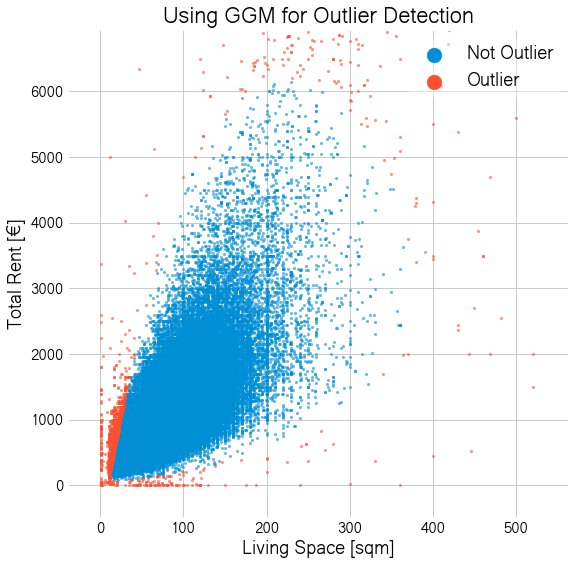

In [442]:
fig, ax = plt.subplots(figsize=(9,9))
max_space = d[d.outlier == "no_outlier"].livingSpace.max()
max_rent = d[d.outlier == "no_outlier"].totalRent.max()
ax.scatter(x=d[d.outlier == "no_outlier"].livingSpace_m, c=blue, alpha=0.6,
              y=d[d.outlier == "no_outlier"].totalRent_m, label="Not Outlier", s=6)
ax.scatter(x=d[d.outlier == "outlier"].livingSpace_m, c=red, alpha=0.6,
              y=d[d.outlier == "outlier"].totalRent_m, label="Outlier", s=6)
ax.set_xlim(-40, max_space + 200)
ax.set_ylim(-500, max_rent + 800)
ax.set_title("Using GGM for Outlier Detection")
leg = ax.legend(markerscale=6)
for lh in leg.legendHandles:
    lh.set_alpha(1)
ax.set(xlabel="Living Space [sqm]", ylabel="Total Rent [€]")
plt.show()

Especially in the upper right we can see that the cut-off window is now elliptic instead of rectangular. Also good to see that points with a living space above 200sqm with rents below 1000€ are classified as outliers. That seems reasonable for me. Same for flat with a living space less than 80sqm with a rent above 2000€ or 3000€. Also seems reasonable.
However, in the lower left we see again a rather hard threshold going through our blob of data points. That doesn't look much better to what we had before. Indeed, if we look at some outliers from the lower left, we find some (depressing) realistic examples, such as this tiny flat in one of the most popular areas of Munich, newly renovated with high quality furniture for a total rent of 900€. Depressingly expensive but not unrealistic.

In [443]:
pd.options.display.max_colwidth = 200
ex1 = d[["totalRent", "livingSpace", "description", "regio2"]][d.outlier == "outlier"].iloc[0]
print(ex1[["totalRent", "livingSpace", "regio2"]]); ex1.description[0:545]

totalRent          900
livingSpace         18
regio2         München
Name: 46, dtype: object


'Ein kleiner möblierter Traum zwischen Englischem Garten und Münchner Freiheit.  In dieser kürzlich kernsanierten kleinen Wohnung ist buchstäblich alles neu. Vom hochwertigen Bad mit großem Handtuchwärmer, über die neue Einbauküche aus dem Küchenstudio, die wunderschönen Landhausdielen aus massivem Eichenholz, dem neuen großen Fenster mit elektrischer Rollladensteuerung in den ruhigen Innenhof, bis hin zu den Möbeln, Lampen und dem internetfähigen TV.\n\nKosten für Strom, Heizung und Kabelfernsehen sind in den Nebenkosten bereits enthalten.\n\n'

## Gaussian Mixtures enhanced

Personally, I prefer to throw away as little as possible. So I would like to keep points such as the one above in my data set. Also, imagine we would want to analyse afterwards how rent prices developed in Munich. Throwing out these examples would make Munich look cheaper than it actually is.
One option would be to now play around with the threshold until you get a result you like. I often found this to be very difficult and the results not necessarily very satisfying. One problem I also encountered is that some outliers that are really very far out there (think e.g. a rent of 120,000€), these points influenced the fitting algorithm so that the fitted multivariate normal distribution was very wide. This then would mean that quite a few real outliers would easily be missed when increasing the threshold.
So I came up with the following method:
What if instead of fitting on the whole data set, we only fit the outlier detector on a small subset. After all, outliers are by definition rare and when we fit on a small subsample there is a high probability that it doesn't contain outliers which then makes it easier to detect outliers. However, you might easily be unlucky with the random sample you got, either then finding way too many or too little outliers. Thus, instead of just sampling and fitting once, I repeatedly sample and fit. Each time fitting on a small sample, predicting on the whole data, and then taking the mean of how often a point was classified as an outlier. This way, I also get a probability how likely a point is to be an outlier! Neat!

I experimented a bit which settings go best and I found that for a data set as big as this one, fitting on 1% of the data gives good results. For the number of iterations, I'm using 100 here but found 30 to 40 iterations to also work fine. I have found 30 iterations to be the lowest number of iterations that still gives relatively stable results. If you use lower number of iterations, you'll might end up with a very different number of outliers each time you run it.

In [444]:
def prob_outlier(outlier_detector_pipe, data, iterations=100, p=0.01):
    sample_size = int(len(data) * p)

    outlier_ar = np.empty((0, len(data)) )
    for i in range(iterations):
        outlier_detector_pipe.fit(data.sample(sample_size))

        outlier_ar = np.append(outlier_ar,  [outlier_detector_pipe.predict(data)], axis=0)

    outlier = (outlier_ar == -1).mean(axis=0)
    return outlier

num_cols = ["logRent", "logSpace"]

d["outlier"] = prob_outlier(pipe, d[num_cols])

After thus obtaining outlier probabilities, we can have a short look at the distribution of these probabilities:

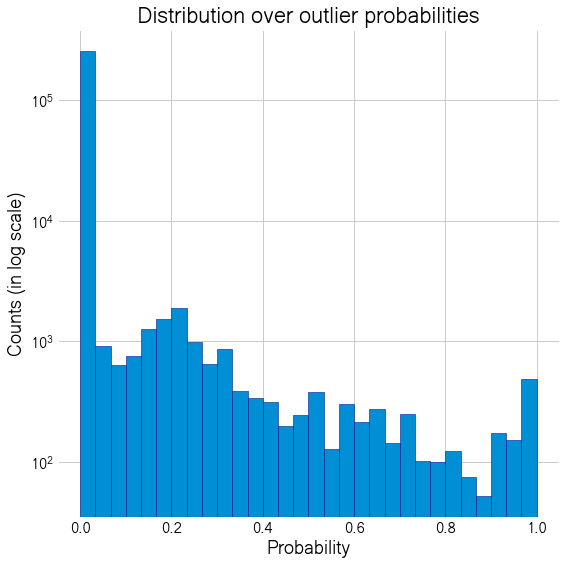

In [445]:
plt.hist(d["outlier"], log=True, bins=30, ec="darkblue")
plt.title("Distribution over outlier probabilities")
plt.xlabel("Probability")
plt.ylabel("Counts (in log scale)")
plt.show()

Most points are never classified as outliers, makes sense, most points should not be outlier. There is a small number of points that always get classified as outliers, these are the points where we can be very sure that they're outliers.
I will use a rather conservative threshold and declare everything above 0.97 as outlier:

In [446]:
np.sum(d["outlier"] > 0.97)

339

Remember, with the IQR rule we identified ~1500 outliers and with the Gaussian mixture ~1700. We reduced the number of outliers by more than half! If you care about throwing away as little as possible, this is great! And even if you want to throw away more, it is very easy to change the threshold to be less conservative.

Let's have a look at the points we detect as outliers:

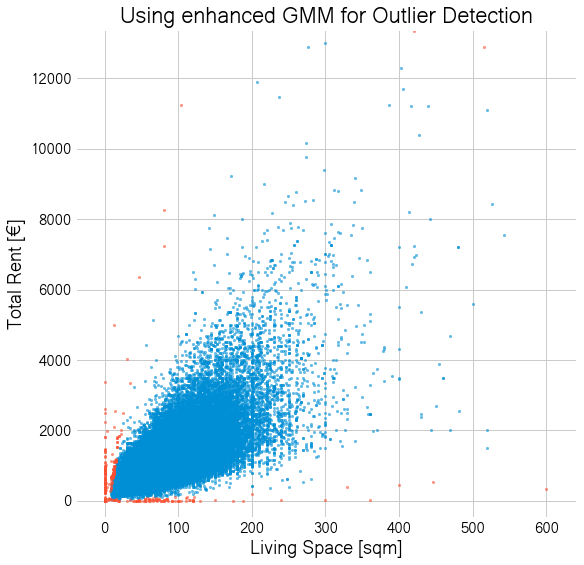

In [447]:
fig, ax  = plt.subplots(figsize=(9,9))
d["outlier_pred"] = np.where(d["outlier"] > 0.97, "outlier", "no_outlier")
max_space = d[d.outlier_pred == "no_outlier"].livingSpace.max()
max_rent = d[d.outlier_pred == "no_outlier"].totalRent.max()

ax.scatter(x=d[d.outlier_pred == "no_outlier"].livingSpace_m, c=blue, alpha=0.6,
              y=d[d.outlier_pred == "no_outlier"].totalRent_m, label="Not Outlier", s=6)
ax.scatter(x=d[d.outlier_pred == "outlier"].livingSpace_m, c=red, alpha=0.6,
              y=d[d.outlier_pred == "outlier"].totalRent_m, label="Outlier", s=6)
ax.set_title("Using enhanced GMM for Outlier Detection")
ax.set(xlabel="Living Space [sqm]", ylabel="Total Rent [€]")
ax.set_xlim(-40, max_space + 100)
ax.set_ylim(-500, max_rent + 400)
plt.show()

We still remove all the super far out outliers and all flats where either the living space or total rent is very close to zero but now removes much less of the very small but expensive flats (that are probably either in places like Munich or shared flats).
We can have a look at the descriptions of some of the outliers:

In [448]:
d[["totalRent", "livingSpace","regio2", "description", ]][d.outlier_pred == "outlier"].head(10)

,totalRent,livingSpace,regio2,description
467,900.00,11.00,München,"Hello, we are homefully and this is our flat Marcello.\n\nLive in the heart of Munich with a nice view over the beautiful skyline of the city! Just across the street is the famous Viktualienmarkt ..."
2828,4020.00,30.00,Märkisch_Oderland_Kreis,"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ..."
3377,1655.00,17.00,Frankfurt_am_Main,"Diese Boardinghouse Anlage – 2 Jahre jung - befindet sich in einer zentralen Lage in Frankfurt am Main, Nähe Hauptbahnhof und Messe. Perfekt um schnell in alle Stadtteile oder in die City zu gelan..."
3546,20466.12,362.88,München,"Dieses einzigartige, elegante und lichtdurchflutete Penthouse befindet sich am Anfang der exklusiven und ruhigen Königinstrasse, welche hier nur auf der westlichen Seite bebaut ist. Gegenüber auf ..."
4896,1.00,60.00,Teltow_Fläming_Kreis,Das Objekt befindet sich im 3. Obergeschoss in einer waldreichen Lage. In der Wohnung sind noch kleinere Renovierungsarbeiten durchzuführen.
4901,1450.00,0.00,Aschaffenburg,Ihr möbliertes Apartment! \nSie benötigen aufgrund beruflichen oder privatem Anlass ein Apartment für einen bestimmten Zeitraum?\n\nDann sind Sie hier genau richtig! Wir bieten Ihnen \n-flexible B...
6811,780.00,0.00,Rems_Murr_Kreis,"Das Objekt verfügt über vier hübsche Zimmer mit Eßdiele und 2 Balkone. Am Südhang mit Aussicht gelegen. \nKaltmiete 780,- Euro + Nebenkosten + Garage + 3 Monatsmieten Kaution.\nEnergieausweis in A..."
8871,5000.00,12.00,Märkisch_Oderland_Kreis,NaN
10642,35.00,15.00,Meißen_Kreis,diese Garage liegt im Statdteil Spitzgrung \nStadt in Richtung Spitzgrund unter Berliner Bahn\nhindurch nach ca. 30 m erste Einfahrt links hoch durch eine Hecke auf Garagenhof bestehend aus 2 Reih...
10995,1890.00,22.00,Frankfurt_am_Main,"Diese Boardinghouse Anlage – 2 Jahre jung - befindet sich in einer zentralen Lage in Frankfurt am Main, Nähe Hauptbahnhof und Messe. Perfekt um schnell in alle Stadtteile oder in die City zu gelan..."


We see a few objects for which it seems someone just forgot to enter the correct living space. Quite a few others are boarding houses and short term rentals. The lorem ipsum flat for more than 4000€ has also correctly been identified as outlier. There's one penthouse in Munich for 20,000€ where I'm not sure if it might be the real total rent, I'm not really familiar with rental prices of penthouses.


## Going beyond two dimensions
A nice thing about the Gaussian mixture outlier detection method is, that it can easily be extended to more than two columns. In this data set for example there are two more variables that also commonly have input errors: the number of rooms and the construction year.
For the construction year, we have different options to use it in our model: either use as is or use the log transformed age of a building. Unfortunately, both ways have disadvantages: If we use the construction year as is, we will detect many very old houses as outliers and even though buildings from the middle age are rare, Germany has quite a few cities with many very old buildings. If instead we use the log transformed age, we miss many outliers: there are for example suspiciously many buildings constructed in 1111. For these kind of outliers, we would need a different approach. 
For this analysis, I used the log transformed age and also log transformed the number of rooms. The later helps in identifying cases where the number of rooms is too high for the amount of living space. As a high number of observations also do not have a construction year, I will do this part only on a subset.

In [505]:
d["age"] = 2021.5 - d["yearConstructed"]
d["logAge"] = np.log(d["age"])
d["logRooms"] = np.log(d["noRooms"])

mask = d["logAge"].notnull()
d_sub = d[mask].copy()

d_sub["outlier"] = np.nan
d_sub["outlier"] = prob_outlier(pipe, d_sub[["logRent", "logSpace", "logRooms", "logAge"]])

In [513]:
d_sub[d_sub.outlier >= 0.8][["totalRent", "yearConstructed", "livingSpace", "regio2", "noRooms", "description"]]\
    .sort_values(by="noRooms", ascending=False)\
    .head(10)

,totalRent,yearConstructed,livingSpace,regio2,noRooms,description
103393,422.0,1999.0,61.17,Chemnitz,999.99,NaN
160185,445.0,1957.0,53.00,Oberbergischer_Kreis,230.00,Wir präsentieren Ihnen hier eine sehr schöne und gepflegte 2- Zimmer Wohnung in Radevormwald. Die Wohnung bietet einem 1-2 Personenhaushalt ausreichend viel Platz und vermittelt durch die gute Gru...
134795,565.0,2014.0,20.00,Heidelberg,221.00,"Das Gebäude befindet sich in dem jüngsten Stadtteil Heidelbergs, der Bahnstadt. \nDen Mietern steht kostenlos ein Fitnessraum zur Verfügung. \nEbenso Waschmaschinen und Trockner gegen Bezahlung."
225073,350.0,1994.0,30.00,Mittelsachsen_Kreis,160.00,"Die Wohnparkanlage ""Auf der Goldenen Höhe"" liegt im südlichen Teil der Stadt Waldheim, am Ortsrand des Stadtteiles Schönberg. \nHierbei handelt es sich um ein allgemeines Wohngebiet, das heißt den..."
25529,395.0,1993.0,14.00,Hannover,140.00,"In der ruhigen Dreyerstraße Nr. 8 + 9 gelegen, erstrecken sich die beiden Apartmenthäuser entlang des Leinebogens. Wohnen könnt ihr hier auf sechs Ebenen mit Blick auf ganz Hannover.\n\n\nDer Gebä..."
172439,900.0,2001.0,100.00,Harburg_Kreis,100.00,Die 3 Zimmerwohnung befindet sich in einem Wohn- und Geschäftshaus in der Bahnhofstr. 16 in 21629 Neu Wulmstorf. In der unmittelbaren Umgebung befinden sich sämtliche Geschäfte des täglichen Bedar...
116132,1970.8,2018.0,3.00,Berlin,99.50,Die hochwertige Etagenwohnung in der Delbrückstraße 41 liegt im Vorderhaus eines Mehrfamilienhauses in Berlin-Neukölln. Die 3-Zimmer-Wohnung im 3. OG ist ca. 99 m² groß und liegt in sonniger Süd-A...
231370,2230.0,1960.0,186.61,Hannover,79.00,Sie wollten schon immer in der City von Hannover wohnen? Dann sind Sie hier an der richtigen Adresse. Sie können in dieser großzügig geschnittenen 6-Zimmer-Wohnung sicher viele Ihrer Wohnträume ve...
89830,911.0,2019.0,2257.88,Nürnberger_Land_Kreis,75.50,"*****Bitte beachten Sie, der angegebene Preis im Portal betrifft die günstigste Wohnung. Beachten Sie bitte die Preisaufstellung in der Beschreibung!******\n\n\nIn der Stadtmitte in der Nähe des B..."
162001,1500.0,1960.0,150.00,Wuppertal,45.00,Doppelhaushälfte 60er Jahre mit nicht einsehbarer großer Terrasse und Garten auf wunderschönem Grundstück in bevorzugter Lage von Wuppertal-Katernberg.


They are quite a few cases where whole appartment blocks are sold where the living space and total rent then often denotes the living space and total rent of a single unit but the number of rooms denote the number of appartment units that are up for rent. 

Let's have a short look at the plot for living space versus number of rooms:

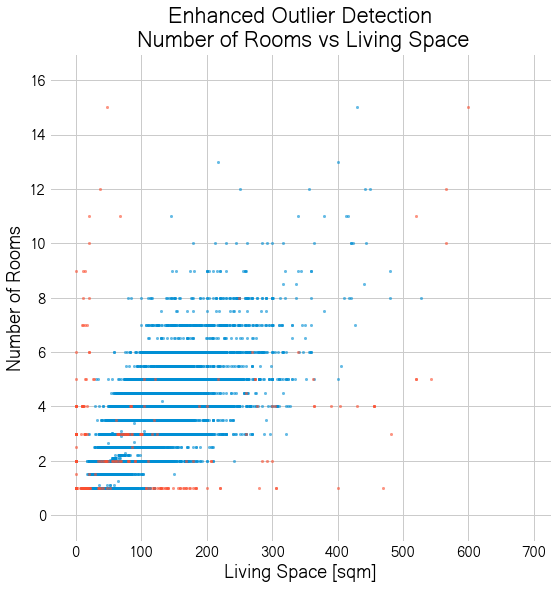

In [516]:
fig, ax  = plt.subplots(figsize=(9,9))
d_sub["outlier_pred"] = np.where(d_sub["outlier"] >= 0.8, "outlier", "no_outlier")
max_space = d_sub[(d_sub.outlier_pred == "no_outlier") ].livingSpace.max()
max_rooms = d_sub[(d_sub.outlier_pred == "no_outlier") ].noRooms.max()
ax.scatter(x=d_sub[d_sub.outlier_pred == "no_outlier"].livingSpace_m, c=blue, alpha=0.6,
              y=d_sub[d_sub.outlier_pred == "no_outlier"].noRooms, label="Not Outlier", s=6)
ax.scatter(x=d_sub[d_sub.outlier_pred == "outlier"].livingSpace_m, c=red, alpha=0.6,
              y=d_sub[d_sub.outlier_pred == "outlier"].noRooms, label="Outlier", s=6)

#sns.scatterplot(x="livingSpace", y="noRooms", hue="outlier_pred", palette="Set1",
#                hue_order = ["outlier", "no_outlier"],
#                data=d_sub,  alpha=0.5, ax=ax, linewidth=0)
ax.set_xlim(-40, max_space + 200)
ax.set_ylim(-1, max_rooms + 2)
ax.set(xlabel="Living Space [sqm]", ylabel="Number of Rooms", title="Enhanced Outlier Detection\n Number of Rooms vs Living Space")
plt.show()

The method identifies everything with more than 15 rooms as outlier and cases with a a very small living space (around less than 30sqm) with too many rooms as outliers. Great! It also thinks that flats with a very large living area above e.g. 100sqm but with only one room are likely outliers. That sounds very reasonable to  me. 

## Summary

In general, outlier detection is a hard problem: what constitutes an outlier is often not very obvious and can depend on the context. I found it useful to check a few cases by hand and see if I can identify an underlying cause. Sometimes, we can use our own domain knowledge and then identify these problematic cases in a more efficient way. For example, in this data set there are many shared flats with misleading values for the living space. A simple regex or more sophisticated text analysis on the description might be more efficient to identify these cases. 

In my experience, results improve significantly if variables are transformed appropriately. Both the Gaussian mixture method and the IQR rule assume that our data follows a normal distribution and results are suboptimal if our data does not. Of course, there are other outlier detection methods that don't assume normality but they always assume something and it is important to be aware of assumptions and make sure they are met. 
The assumptions then also determine what kind of outliers we can detect. As the methods used in this analysis assume normality and define outliers as points that are outside the center, it won't detect outliers such as flats built in 1111. There might be real flats build in 1111 and there definitely are quite a few real offers in this data built aroud the 10th century but most flats built in 1111 in this data set are probably not that old.